In [1]:
# Loading Libraries
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import log_hyperu as hyperu
import tgr as tgr
import math
import time
import csv

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [133]:
#LASSO
# Define your model
starttime = time.time()
class LinearRegressionLasso(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionLasso, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Define hyperparameters
input_size = 10
output_size = 1
learning_rate = 0.01
num_epochs = 1000
lambda_lasso = 1 # L1 regularization parameter

# Create the model
model = LinearRegressionLasso(input_size, output_size)

# Define loss function (MSE loss with L1 regularization)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, Y)

    # Total loss with L1 regularization
    l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())

    loss = loss + lambda_lasso * l1_norm
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

endtime = time.time()
print(f'With {num_epochs} iterations, Regular LASSO Regularization took {round(endtime-starttime,4)} seconds. On this system, that is roughly {(endtime-starttime)/num_epochs} seconds per iteration.')

# After training, you can access the learned coefficients
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.data.tolist()}')
        coefs_LASSO = param.data.tolist()


Epoch [100/1000], Loss: 10.6036
Epoch [200/1000], Loss: 7.0338
Epoch [300/1000], Loss: 6.6343
Epoch [400/1000], Loss: 6.5833
Epoch [500/1000], Loss: 6.5743
Epoch [600/1000], Loss: 6.5747
Epoch [700/1000], Loss: 6.5778
Epoch [800/1000], Loss: 6.5804
Epoch [900/1000], Loss: 6.5821
Epoch [1000/1000], Loss: 6.5785
With 1000 iterations, Regular LASSO Regularization took 1.3717 seconds. On this system, that is roughly 0.0013716657161712646 seconds per iteration.
linear.weight: [[-0.08131898939609528, 0.11880242824554443, 5.130025863647461, 4.099651336669922, 0.0024799692910164595, -0.008265404962003231, 6.229494094848633, -0.03251353278756142, 0.006142516154795885, -0.11067549884319305]]


In [2]:
def ComputeValidationLoss(model, X_val, y_val):
    model.eval()
    mse_criterion = nn.MSELoss()
    total_loss = 0.0

    with torch.no_grad():
        outputs = model(X_val).squeeze()
        loss = mse_criterion(outputs, y_val)
        total_loss = loss.item()

    return total_loss


## Prediction Simulation

In [1]:
import itertools

n_samples = [50]#[50, 100, 500, 1000]
n_features = [10]#[3, 10, 25]
n_nonzero = [0.5]#[0.1, 0.5, 0.9]

scenario_combinations = list(itertools.product(n_samples, n_features, n_nonzero))

#### Retrieve Optimal $\lambda$ Values

In [3]:
# Step 0: Import Libraries
import pandas as pd
from datetime import datetime
import torch
import math
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt
import tgr as tgr
import log_hyperu as hyperu

# Step 0.1: Define necessary classes and functions

class LinearRegression(nn.Module):
    def __init__(self, n_features):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(n_features, 1, bias=False)
        
    def forward(self, x):
        return self.linear(x)

def train_model(model, X_train, y_train, lr=0.01, n_epochs=1000):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        model.train()
        
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
    return model

def lasso_loss(output, target, model, lasso_reg_strength):
    mse_loss = nn.MSELoss()(output, target)
    lasso_loss = lasso_reg_strength * torch.norm(model.linear.weight, 1)
    return mse_loss + lasso_loss 

def ridge_loss(output, target, model, ridge_reg_strength):
    mse_loss = nn.MSELoss()(output, target)
    ridge_loss = ridge_reg_strength * torch.norm(model.linear.weight, 2)**2
    return mse_loss + ridge_loss

def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
    mse_loss = nn.MSELoss()(output, target)
    phi = torch.tensor((2*c)/((kappa**2)*a))
    tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))
    return mse_loss + tgr_loss

def arctan_loss(output, target, model, arctan_reg_strength):
    mse_loss = nn.MSELoss()(output, target)
    arctan_loss = arctan_reg_strength*torch.sum((2/np.pi) * torch.arctan(torch.abs(model.linear.weight)))
    return mse_loss + arctan_loss

def gaussian_loss(output, target, model, gaussian_reg_strength):
    mse_loss = nn.MSELoss()(output, target)
    gaussian_loss = gaussian_reg_strength*torch.sum(1 - math.e**(-10*model.linear.weight**2))
    return mse_loss + gaussian_loss

# Step 1: Set random seed for reproducibility - (Iterate through multiple ones to increase statistical rigour)
torch.manual_seed(123) 
np.random.seed(123) 

# Step 1.1: Define Lambda Grid and other key parameters
lambda_grid = [0.01*i for i in range(0,10,1)] # From 0 to 1 with 0.01 steps
n_epochs = 500
n_runs = 3 # Set the time on how many optimal lambdas should be found for each sceario.
metric = 'MSE' # Either MSE of Dev (Deviation for Variable Selection)
optimal_lambda_list = list() # list storing the optimal values for each method and each scenario

# Step 2: Iterate through scenarios
for scen in scenario_combinations:
    print(f'Started Scenario {scen}')
    scen_samples = scen[0]
    scen_features = scen[1]
    scen_nonzero = math.ceil(scen[2]*scen[1])
    
    # Step 2.1: Create Sample Data Sets
    # True coefficients with sparsity (many coefficients are zero)
    true_coefficients = torch.zeros(scen_features)
    true_coefficients[:scen_nonzero] = torch.randn(scen_nonzero)*5

    # Generate features
    X = torch.randn(scen_samples, scen_features)
    for run in range(n_runs):
        print(f'--Started Run {run+1} of Scenario {scen}!')

        # Generate targets with noise
        noise = torch.randn(scen_samples) * 0.5
        y = X @ true_coefficients + noise

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Step 3: Train models
        lasso_best_loss = 10000000000 # Hard Gecoded!
        ridge_best_loss = 10000000000
        tgr1_best_loss = 10000000000
        tgr2_best_loss = 10000000000
        tgr3_best_loss = 10000000000
        arctan_best_loss = 10000000000
        gaussian_best_loss = 10000000000

        for reg_strength in lambda_grid:
            print(f'----Started Reg-Strength {reg_strength} of Run {run+1} of Scenario {scen}!')
            # Step 3.1: LASSO
            lasso_model = LinearRegression(scen_features)
            optimizer = torch.optim.SGD(lasso_model.parameters(), lr=0.01)

            for epoch in range(n_epochs):
                lasso_model.train()
                optimizer.zero_grad()
                outputs = lasso_model(X_train).squeeze()
                loss = lasso_loss(outputs, y_train, lasso_model, reg_strength)
                loss.backward()
                optimizer.step()
            
            val_loss = ComputeValidationLoss(lasso_model, X_test, y_test)
            if val_loss < lasso_best_loss:
                lasso_best_lamda = reg_strength
                lasso_best_loss = val_loss

            # Step 3.2: Ridge
            ridge_model = LinearRegression(scen_features)
            optimizer = torch.optim.SGD(ridge_model.parameters(), lr=0.01)
            
            for epoch in range(n_epochs):
                ridge_model.train()
                optimizer.zero_grad()
                outputs = ridge_model(X_train).squeeze()
                loss = ridge_loss(outputs, y_train, ridge_model, reg_strength)
                loss.backward()
                optimizer.step()
            
            val_loss = ComputeValidationLoss(ridge_model, X_test, y_test)
            if val_loss < ridge_best_loss:
                ridge_best_lamda = reg_strength
                ridge_best_loss = val_loss
                
            # Step 3.3: TGR Setting 1
            tgr_model1 = LinearRegression(scen_features)
            optimizer = torch.optim.SGD(tgr_model1.parameters(), lr=0.01)

            for epoch in range(n_epochs):
                tgr_model1.train()
                optimizer.zero_grad()
                outputs = tgr_model1(X_train).squeeze()
                loss = tgr_loss(outputs, y_train, tgr_model1, reg_strength, 0.75, 0.1, 2)
                loss.backward()
                nn.utils.clip_grad_norm_(tgr_model1.parameters(), 1.0)
                optimizer.step()

            val_loss = ComputeValidationLoss(tgr_model1, X_test, y_test)

            if val_loss < tgr1_best_loss:
                tgr1_best_lamda = reg_strength
                tgr1_best_loss = val_loss
            
            # Step 3.4: TGR Setting 2
            tgr_model2 = LinearRegression(scen_features)
            optimizer = torch.optim.SGD(tgr_model2.parameters(), lr=0.01)

            for epoch in range(n_epochs):
                tgr_model2.train()
                optimizer.zero_grad()
                outputs = tgr_model2(X_train).squeeze()
                loss = tgr_loss(outputs, y_train, tgr_model2, reg_strength, 5, 0.01, 2)
                loss.backward()
                nn.utils.clip_grad_norm_(tgr_model2.parameters(), 1.0)
                optimizer.step()

            val_loss = ComputeValidationLoss(tgr_model2, X_test, y_test)

            if val_loss < tgr2_best_loss:
                tgr2_best_lamda = reg_strength
                tgr2_best_loss = val_loss

            # Step 3.5: TGR Setting 3
            tgr_model3 = LinearRegression(scen_features)
            optimizer = torch.optim.SGD(tgr_model3.parameters(), lr=0.01)

            for epoch in range(n_epochs):
                tgr_model3.train()
                optimizer.zero_grad()
                outputs = tgr_model3(X_train).squeeze()
                loss = tgr_loss(outputs, y_train, tgr_model3, reg_strength, 0.51, 0.01, 1)
                loss.backward()
                nn.utils.clip_grad_norm_(tgr_model3.parameters(), 1.0)
                optimizer.step()

            val_loss = ComputeValidationLoss(tgr_model3, X_test, y_test)

            if val_loss < tgr3_best_loss:
                tgr3_best_lamda = reg_strength
                tgr3_best_loss = val_loss
        
            # Step 3.6: Arctan
            arctan_model = LinearRegression(scen_features)
            optimizer = torch.optim.SGD(arctan_model.parameters(), lr=0.01)

            for epoch in range(n_epochs):
                arctan_model.train()
                optimizer.zero_grad()
                outputs = arctan_model(X_train).squeeze()
                loss = arctan_loss(outputs, y_train, arctan_model, reg_strength)
                loss.backward()
                nn.utils.clip_grad_norm_(arctan_model.parameters(), 1.0)
                optimizer.step()
                
            val_loss = ComputeValidationLoss(arctan_model, X_test, y_test)
            
            if val_loss < arctan_best_loss:
                arctan_best_lamda = reg_strength
                arctan_best_loss = val_loss
                                
            # Step 3.7: Gaussian
            gaussian_model = LinearRegression(scen_features)
            
            for epoch in range(n_epochs):
                gaussian_model.train()
                optimizer.zero_grad()
                outputs = gaussian_model(X_train).squeeze()
                loss = gaussian_loss(outputs, y_train, gaussian_model, reg_strength)
                loss.backward()
                nn.utils.clip_grad_norm_(gaussian_model.parameters(), 1.0)
                optimizer.step()
                
            val_loss = ComputeValidationLoss(gaussian_model, X_test, y_test)
                        
            if val_loss < gaussian_best_loss:
                gaussian_best_lamda = reg_strength
                gaussian_best_loss = val_loss
            print(f'----Finished Reg-Strength {reg_strength} of Run {run+1} of Scenario {scen}!')
        print(f'--Finished Run {run+1} of Scenario {scen}!')
        tmp = [scen, run+1, lasso_best_lamda, ridge_best_lamda, tgr1_best_lamda, tgr2_best_lamda, tgr3_best_lamda, arctan_best_lamda, gaussian_best_lamda]
        optimal_lambda_list.append(tmp)
    print(f'Finished {scen}')

df_best_lambdas = pd.DataFrame(optimal_lambda_list, columns=["Scenario", "Run", "LASSO", "Ridge", "TGR Setting 1", "TGR Setting 2", "TGR Setting 3", "Arctan", "Gaussian"])

current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f"optimal_lambda_{current_datetime}.xlsx"

# Export to Excel
df_best_lambdas.to_excel(file_name, index=False)

Started Scenario (50, 10, 0.5)
--Started Run 1 of Scenario (50, 10, 0.5)!
----Started Reg-Strength 0.0 of Run 1 of Scenario (50, 10, 0.5)!
----Finished Reg-Strength 0.0 of Run 1 of Scenario (50, 10, 0.5)!
----Started Reg-Strength 0.01 of Run 1 of Scenario (50, 10, 0.5)!
----Finished Reg-Strength 0.01 of Run 1 of Scenario (50, 10, 0.5)!
----Started Reg-Strength 0.02 of Run 1 of Scenario (50, 10, 0.5)!
----Finished Reg-Strength 0.02 of Run 1 of Scenario (50, 10, 0.5)!
----Started Reg-Strength 0.03 of Run 1 of Scenario (50, 10, 0.5)!
----Finished Reg-Strength 0.03 of Run 1 of Scenario (50, 10, 0.5)!
----Started Reg-Strength 0.04 of Run 1 of Scenario (50, 10, 0.5)!
----Finished Reg-Strength 0.04 of Run 1 of Scenario (50, 10, 0.5)!
----Started Reg-Strength 0.05 of Run 1 of Scenario (50, 10, 0.5)!
----Finished Reg-Strength 0.05 of Run 1 of Scenario (50, 10, 0.5)!
----Started Reg-Strength 0.06 of Run 1 of Scenario (50, 10, 0.5)!
----Finished Reg-Strength 0.06 of Run 1 of Scenario (50, 10, 0.5

In [57]:
import itertools
import os

# Set random seed for reproducibility
torch.manual_seed(123) # 42
np.random.seed(123) # 42

# Step 0: Define necessary functions

class LinearRegression(nn.Module):
    def __init__(self, n_features):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(n_features, 1, bias=False)
        
    def forward(self, x):
        return self.linear(x)

def train_model(model, X_train, y_train, lr=0.01, n_epochs=500):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        model.train()
        
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
    return model

def lasso_loss(output, target, model, lasso_reg_strength):
    mse_loss = nn.MSELoss()(output, target)
    lasso_loss = lasso_reg_strength * torch.norm(model.linear.weight, 1)
    return mse_loss + lasso_loss

def ridge_loss(output, target, model, ridge_reg_strength):
    mse_loss = nn.MSELoss()(output, target)
    ridge_loss = ridge_reg_strength * torch.norm(model.linear.weight, 2)**2
    return mse_loss + ridge_loss

def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
    mse_loss = nn.MSELoss()(output, target)
    phi = torch.tensor((2*c)/((kappa**2)*a))
    tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))
    return mse_loss + tgr_loss

def arctan_loss(output, target, model, arctan_reg_strength):
    mse_loss = nn.MSELoss()(output, target)
    arctan_loss = arctan_reg_strength*torch.sum((2/np.pi) * torch.arctan(torch.abs(model.linear.weight)))
    return mse_loss + arctan_loss

def gaussian_loss(output, target, model, gaussian_reg_strength):
    mse_loss = nn.MSELoss()(output, target)
    gaussian_loss = gaussian_reg_strength*torch.sum(1 - math.e**(-10*model.linear.weight**2))
    return mse_loss + gaussian_loss

# Step 1: Generate synthetic data using scenario
n_epochs = 500
runs = 25

n_samples = [50, 100, 500, 1000]
n_features = [3, 10, 25]
n_nonzero = [0.1, 0.5, 0.9]

scenario_combinations = list(itertools.product(n_samples, n_features, n_nonzero))

# Make new simulation folder
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
simulation_folder_path = f'Simulation_{current_datetime}'
os.makedirs(simulation_folder_path, exist_ok=True)

counter=0
for scen in scenario_combinations:
    output_list = list() # Contains Tuples with (METHOD, LAMBDA, LOSS, COEFS)
    counter = counter + 1
    for run in range(runs):
        n_samples = scen[0]
        n_features = scen[1]
        n_nonzero = math.ceil(scen[2]*scen[1])
        # True coefficients with sparsity (many coefficients are zero)
        true_coefficients = torch.zeros(n_features)
        true_coefficients[:n_nonzero] = torch.randn(n_nonzero)

        # Generate features
        X = torch.randn(n_samples, n_features)

        # Generate targets with noise
        noise = torch.randn(n_samples) * 0.5
        y = X @ true_coefficients + noise

        # Step 2: Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Step 3: Implement OLS and Lasso regression using PyTorch

        # Train OLS model
        ols_model = LinearRegression(n_features)
        ols_model = train_model(ols_model, X_train, y_train)
        
        # Train Lasso model
        lasso_reg_strength = 0.13
        lasso_model = LinearRegression(n_features)
        optimizer = torch.optim.SGD(lasso_model.parameters(), lr=0.01)
        for epoch in range(n_epochs):
            lasso_model.train()
            optimizer.zero_grad()
            outputs = lasso_model(X_train).squeeze()
            loss = lasso_loss(outputs, y_train, lasso_model, lasso_reg_strength)
            loss.backward()
            optimizer.step()
            
            
        # Train Rdige model
        ridge_reg_strength = 0.58
        ridge_model = LinearRegression(n_features)
        optimizer = torch.optim.SGD(ridge_model.parameters(), lr=0.01)
        for epoch in range(n_epochs):
            ridge_model.train()
            optimizer.zero_grad()
            outputs = ridge_model(X_train).squeeze()
            loss = ridge_loss(outputs, y_train, ridge_model, ridge_reg_strength)
            loss.backward()
            optimizer.step()

        # Arctan Model
        arctan_reg_strength = 0.18
        arctan_model = LinearRegression(n_features)
        for epoch in range(n_epochs):
            arctan_model.train()
            optimizer.zero_grad()
            outputs = arctan_model(X_train).squeeze()
            loss = arctan_loss(outputs, y_train, arctan_model, arctan_reg_strength)
            loss.backward()
            nn.utils.clip_grad_norm_(arctan_model.parameters(), 1.0)
            optimizer.step()
            
        # Gaussian Model
        gaussian_reg_strength = 0.89
        gaussian_model = LinearRegression(n_features)
        for epoch in range(n_epochs):
            gaussian_model.train()
            optimizer.zero_grad()
            outputs = gaussian_model(X_train).squeeze()
            loss = gaussian_loss(outputs, y_train, gaussian_model, gaussian_reg_strength)
            loss.backward()
            nn.utils.clip_grad_norm_(gaussian_model.parameters(), 1.0)
            optimizer.step()
            
        # Train TGR Model - Setting 1
        tgr_reg_strength = 0.02
        tgr_model1 = LinearRegression(n_features)
        optimizer = torch.optim.SGD(tgr_model1.parameters(), lr=0.01)
        for epoch in range(n_epochs):
            tgr_model1.train()
            optimizer.zero_grad()
            outputs = tgr_model1(X_train).squeeze()
            loss = tgr_loss(outputs, y_train, tgr_model1, tgr_reg_strength, 0.75, 0.1, 2)
            loss.backward()
            nn.utils.clip_grad_norm_(tgr_model1.parameters(), 1.0)
            optimizer.step()
        
        # Train TGR Model - Setting 2
        tgr_reg_strength = 0.04
        tgr_model2 = LinearRegression(n_features)
        optimizer = torch.optim.SGD(tgr_model2.parameters(), lr=0.01)
        for epoch in range(n_epochs):
            tgr_model2.train()
            optimizer.zero_grad()
            outputs = tgr_model2(X_train).squeeze()
            loss = tgr_loss(outputs, y_train, tgr_model2, tgr_reg_strength, 5, 0.01, 2)
            loss.backward()
            nn.utils.clip_grad_norm_(tgr_model2.parameters(), 1.0)
            optimizer.step()

        # Train TGR Model - Setting 3
        tgr_reg_strength = 0.13
        tgr_model3 = LinearRegression(n_features)
        optimizer = torch.optim.SGD(tgr_model3.parameters(), lr=0.01)

        for epoch in range(n_epochs):
            tgr_model3.train()
            optimizer.zero_grad()
            outputs = tgr_model3(X_train).squeeze()
            loss = tgr_loss(outputs, y_train, tgr_model3, tgr_reg_strength, 0.51, 0.01, 1)
            loss.backward()
            nn.utils.clip_grad_norm_(tgr_model3.parameters(), 1.0)
            optimizer.step()
        
        print(f"Run {run+1} of {runs} finished!")
        # END RUNS LOOP
    # END SCENARIO LOOP    

    #df = pd.DataFrame(output_list, columns=["OLS","LASSO","Ridge","TGR1","Arctan","Gaussian","TGR2","TGR3"])
    #file_name = f"loss_scen_{n_samples}_{n_features}_{n_nonzero}.xlsx"
    #file_path = os.path.join(simulation_folder_path, file_name)
    # Export to Excel
    #df.to_excel(file_path, index=False)
    #print(f"Finished Scenario {scen}! {counter} of {len(scenario_combinations)} finished!")


Run 1 of 25 finished!
Run 2 of 25 finished!
Run 3 of 25 finished!
Run 4 of 25 finished!
Run 5 of 25 finished!
Run 6 of 25 finished!
Run 7 of 25 finished!
Run 8 of 25 finished!
Run 9 of 25 finished!
Run 10 of 25 finished!
Run 11 of 25 finished!
Run 12 of 25 finished!
Run 13 of 25 finished!
Run 14 of 25 finished!
Run 15 of 25 finished!
Run 16 of 25 finished!
Run 17 of 25 finished!
Run 18 of 25 finished!
Run 19 of 25 finished!
Run 20 of 25 finished!
Run 21 of 25 finished!
Run 22 of 25 finished!
Run 23 of 25 finished!
Run 24 of 25 finished!
Run 25 of 25 finished!
Finished Scenario (50, 3, 0.1)! 1 of 36 finished!
Run 1 of 25 finished!
Run 2 of 25 finished!
Run 3 of 25 finished!
Run 4 of 25 finished!
Run 5 of 25 finished!
Run 6 of 25 finished!
Run 7 of 25 finished!
Run 8 of 25 finished!
Run 9 of 25 finished!
Run 10 of 25 finished!
Run 11 of 25 finished!
Run 12 of 25 finished!
Run 13 of 25 finished!
Run 14 of 25 finished!
Run 15 of 25 finished!
Run 16 of 25 finished!
Run 17 of 25 finished!
Ru

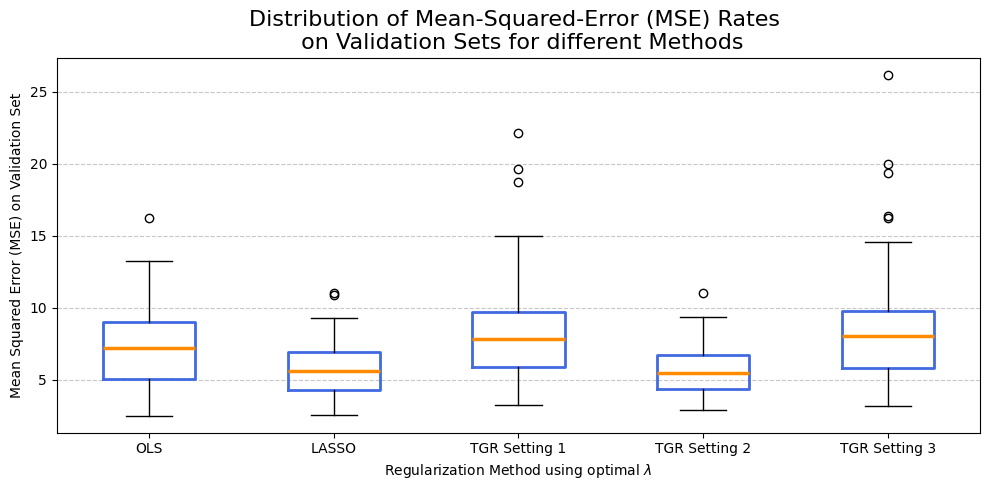

In [33]:
columns_to_plot = [col for col in df.columns if col != "Arctan"]

fig, ax = plt.subplots(figsize=(10, 5))
boxprops = dict(linestyle='-', linewidth=2, color='royalblue')
medianprops = dict(linestyle='-', linewidth=2.5, color='darkorange')

plt.boxplot([df[col] for col in columns_to_plot], labels=columns_to_plot, boxprops=boxprops, medianprops=medianprops)
plt.title('Distribution of Mean-Squared-Error (MSE) Rates \n on Validation Sets for different Methods', fontsize=16)
plt.xlabel('Regularization Method using optimal $\\lambda$', fontsize=10)
plt.ylabel('Mean Squared Error (MSE) on Validation Set', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines only for y-axis
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout to make room for labels
ax.set_xticklabels(['OLS', 'LASSO', 'TGR Setting 1', 'TGR Setting 2', 'TGR Setting 3'])

ax.set_xticks(major_ticks)
plt.tight_layout()
plt.savefig("021_simulation_figures/MSE_Pred_SampleScenario.png")

plt.show()

In [42]:
### Absolut Deviation Plot

# Set random seed for reproducibility
torch.manual_seed(123) # 42
np.random.seed(123) # 42

# Step 1: Generate synthetic data
n_samples = 100
n_features = 25
n_nonzero = 3
runs = 20
n_epochs = 250

ols_dev_list = list()
lasso_dev_list = list()
tgr_dev_S1 = list()
tgr_dev_S2 = list()
tgr_dev_S3 = list()


for run in range(runs):
    # True coefficients with sparsity (many coefficients are zero)
    true_coefficients = torch.zeros(n_features)
    true_coefficients[:n_nonzero] = torch.randn(n_nonzero)

    # Generate features
    X = torch.randn(n_samples, n_features)

    # Generate targets with noise
    noise = torch.randn(n_samples) * 0.5
    y = X @ true_coefficients + noise

    # Step 2: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 3: Implement OLS and Lasso regression using PyTorch
    class LinearRegression(nn.Module):
        def __init__(self, n_features):
            super(LinearRegression, self).__init__()
            self.linear = nn.Linear(n_features, 1, bias=False)
            
        def forward(self, x):
            return self.linear(x)

    def train_model(model, X_train, y_train, lr=0.01, n_epochs=250):
        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        
        for epoch in range(n_epochs):
            model.train()
            
            optimizer.zero_grad()
            outputs = model(X_train).squeeze()
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            
        return model

    # Train OLS model
    ols_model = LinearRegression(n_features)
    ols_model = train_model(ols_model, X_train, y_train)

    # Train Lasso model
    lasso_model = LinearRegression(n_features)
    lasso_reg_strength = 0.13 # Regularization strength

    def lasso_loss(output, target, model, lasso_reg_strength):
        mse_loss = nn.MSELoss()(output, target)
        lasso_loss = lasso_reg_strength * torch.norm(model.linear.weight, 1)
        return mse_loss + lasso_loss

    optimizer = torch.optim.SGD(lasso_model.parameters(), lr=0.01)
    
    for epoch in range(n_epochs):
        lasso_model.train()
        
        optimizer.zero_grad()
        outputs = lasso_model(X_train).squeeze()
        loss = lasso_loss(outputs, y_train, lasso_model, lasso_reg_strength)
        loss.backward()
        optimizer.step()

    # Train TGR Model
    def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
        mse_loss = nn.MSELoss()(output, target)
        phi = torch.tensor((2*c)/((kappa**2)*a))
        tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))

        return mse_loss + tgr_loss

    ## TGR - Setting 1
    tgr_model1 = LinearRegression(n_features)
    optimizer = torch.optim.SGD(tgr_model1.parameters(), lr=0.01)
    

    for epoch in range(n_epochs):
        tgr_model1.train()
        
        optimizer.zero_grad()
        outputs = tgr_model1(X_train).squeeze()
        loss = tgr_loss(outputs, y_train, tgr_model1, 0.03, 0.75, 0.1, 2)
        loss.backward()
        nn.utils.clip_grad_norm_(tgr_model1.parameters(), 1.0)
        optimizer.step()
        
    ## TGR - Setting 2
    tgr_model2 = LinearRegression(n_features)
    optimizer = torch.optim.SGD(tgr_model2.parameters(), lr=0.01)

    for epoch in range(n_epochs):
        tgr_model2.train()
        
        optimizer.zero_grad()
        outputs = tgr_model2(X_train).squeeze()
        loss = tgr_loss(outputs, y_train, tgr_model2, 0.04, 5, 0.01, 2)
        loss.backward()
        nn.utils.clip_grad_norm_(tgr_model2.parameters(), 1.0)
        optimizer.step()

    ## TGR - Setting 3
    tgr_model3 = LinearRegression(n_features)
    optimizer = torch.optim.SGD(tgr_model3.parameters(), lr=0.01)


    for epoch in range(n_epochs):
        tgr_model3.train()
        
        optimizer.zero_grad()
        outputs = tgr_model3(X_train).squeeze()
        loss = tgr_loss(outputs, y_train, tgr_model3, 0.08, 0.51, 0.001, 1)
        loss.backward()
        nn.utils.clip_grad_norm_(tgr_model3.parameters(), 1.0)
        optimizer.step()


    # Step 5: Plot the true and estimated coefficients

    # Get the estimated coefficients
    ols_coefficients = ols_model.linear.weight.detach().numpy().flatten()
    lasso_coefficients = lasso_model.linear.weight.detach().numpy().flatten()
    #arctan_coefficients = arctan_model.linear.weight.detach().numpy.flatten()
    tgr_coefficients_S1 = tgr_model1.linear.weight.detach().numpy().flatten()
    tgr_coefficients_S2 = tgr_model2.linear.weight.detach().numpy().flatten()
    tgr_coefficients_S3 = tgr_model3.linear.weight.detach().numpy().flatten()
    true_coefficients_np = true_coefficients.numpy()

    # Get absolute deviation
    ols_dev_list.append(sum(abs(ols_coefficients-true_coefficients_np)))
    lasso_dev_list.append(sum(abs(lasso_coefficients-true_coefficients_np)))
    tgr_dev_S1.append(sum(abs(tgr_coefficients_S1 - true_coefficients_np)))
    tgr_dev_S2.append(sum(abs(tgr_coefficients_S2 - true_coefficients_np)))
    tgr_dev_S3.append(sum(abs(tgr_coefficients_S3 - true_coefficients_np)))
    
    print(f'Finished run {run} of {runs}')


Finished run 0 of 20
Finished run 1 of 20
Finished run 2 of 20
Finished run 3 of 20


KeyboardInterrupt: 

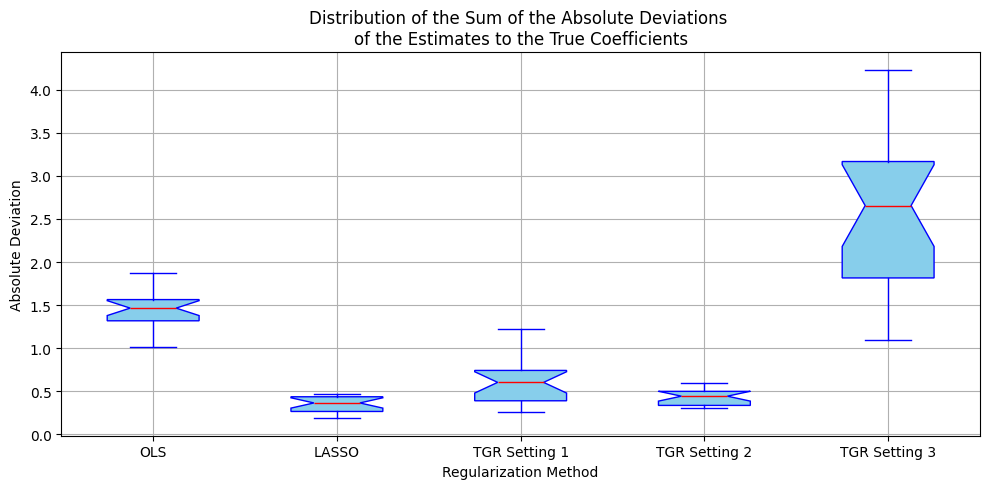

In [40]:
#print(ols_dev_list)
#print(lasso_dev_list)
#print(tgr_dev_list)

# Combine data into a list
data = [ols_dev_list, lasso_dev_list, tgr_dev_S1, tgr_dev_S2, tgr_dev_S3]

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 5))

# Plot box plots
ax.boxplot(data, patch_artist=True, notch=True,
            boxprops=dict(facecolor='skyblue', color='blue'),
            capprops=dict(color='blue'),
            whiskerprops=dict(color='blue'),
            flierprops=dict(color='blue', markeredgecolor='blue'),
            medianprops=dict(color='red'))
plt.title('Distribution of the Sum of the Absolute Deviations \nof the Estimates to the True Coefficients')
ax.set_xlabel('Regularization Method')
ax.set_ylabel('Absolute Deviation')
ax.set_xticklabels(['OLS', 'LASSO', 'TGR Setting 1', 'TGR Setting 2', 'TGR Setting 3'])
major_ticks = np.arange(1, 6, 1)
ax.set_xticks(major_ticks)

# Adjust layout
plt.tight_layout()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Step 5: Plot the true and estimated coefficients

# Get the estimated coefficients
#ols_coefficients = ols_model.linear.weight.detach().numpy().flatten()
#lasso_coefficients = lasso_model.linear.weight.detach().numpy().flatten()
#tgr_coefficients_LASSO = tgr_model1_LASSO.linear.weight.detach().numpy().flatten()
#tgr_coefficients_Special = tgr_model2_Special.linear.weight.detach().numpy().flatten()
#arctan_coefficients = arctan_model.linear.weight.detach().numpy().flatten()
#true_coefficients_np = true_coefficients.numpy()

# Plotting
#fig = plt.figure(figsize=(12, 6))
#ax = fig.add_subplot(1, 1, 1)
#plt.plot(true_coefficients_np, label='True Coefficients', marker='o')
#plt.plot(ols_coefficients, label='OLS Estimated', marker='x')
#plt.plot(lasso_coefficients, label='LASSO Estimated', marker='.')
#plt.plot(tgr_coefficients_LASSO, label='TGR Estimated - LASSO Replica', marker='.')
#plt.plot(tgr_coefficients_Special, label='TGR Estimated - Example', marker='.')
#plt.plot(arctan_coefficients, label='Arctan Estimated', marker='.')
#plt.xlabel('Feature Index')
#plt.ylabel('Coefficient Value')
#plt.title('True vs Estimated Coefficients')

#major_ticks = np.arange(0, 10, 1)
#ax.set_xticks(major_ticks)

#plt.legend()
#plt.grid(True)
#plt.show()


### New Approach to Simulation

In [1]:
import torch
import numpy as np
import scipy.special as sp

"""Unfortunately, it appears that not all approximations of the hyperu function as x -> 0 
are implemented in the scipy library. As such, this is an implementation of those 
appearing in the DLMF (https://dlmf.nist.gov/13.2#iii).
a, b, and z are all tensors of the same shape. The function returns a tensor of the same shape.
"""
def robust_hyperu(a, b, z):
    res = torch.zeros_like(z)
    res.fill_(np.nan)
    small_z = torch.abs(z) < 1e-9

    # Approximation for small z and b > 2
    res = torch.where(torch.logical_and(small_z, b > 2), 
                        torch.exp(torch.lgamma(b - 1) - torch.lgamma(a) + (1 - b) * torch.log(z)),
                        res)

    # Approximation for small z and b = 2
    res = torch.where(torch.logical_and(small_z, b == 2),
                        torch.exp(-torch.lgamma(a) - torch.log(z)),
                        res)

    # Approximation for small z and 1 < b < 2
    res = torch.where(torch.logical_and(torch.logical_and(small_z, b < 2), b > 1),
                        torch.exp(torch.lgamma(b - 1) - torch.lgamma(a) + (1 - b) * torch.log(z)) +
                        torch.exp(-torch.lgamma(1 - b) - torch.lgamma(a - b +1)),
                        res)

    # Approximation for small z and b = 1
    res = torch.where(torch.logical_and(small_z, b == 1),
                        -torch.exp(-torch.lgamma(a) - torch.log(z + torch.digamma(a) + 0.57721566490153286060651209008240243)),
                        res)

    # Approximation for small z and 0 < b < 1
    res = torch.where(torch.logical_and(torch.logical_and(small_z, b < 1), b > 0),
                        torch.exp(torch.lgamma(1 - b) - torch.lgamma(a - b + 1)),
                        res)

    # Approximation for small z and b = 0
    res = torch.where(torch.logical_and(small_z, b == 0),
                        torch.exp(-torch.lgamma(a + 1)),
                        res)

    # Approximation for small z and b < 0
    res = torch.where(torch.logical_and(small_z, b < 0),
                        torch.exp(torch.lgamma(1 - b) - torch.lgamma(a - b + 1)),
                        res)

    # Fill up all where no special case applies
    res = torch.where(torch.isnan(res), sp.hyperu(a, b, z), res)
    return(res)

"""Then, define the log_hyperu function that can be used in autograd
a, b, and x are all tensors of the same shape. The function returns a tensor of the same shape.
Currently, the function is not differentiable with respect to a and b. I'm not entirely sure this is possible anyways 
"""
class log_hyperu(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a, b, x):
        u_res = robust_hyperu(a, b, x)
        result = torch.log(u_res)

        ctx.mark_non_differentiable(a)
        ctx.mark_non_differentiable(b)

        ctx.save_for_backward(a, b, x, u_res)

        return result

    @staticmethod
    def backward(ctx, grad_output):
        a, b, x, u_res = ctx.saved_tensors
        grad_x = grad_output * (-a * torch.div(robust_hyperu(a + 1, b + 1, x), u_res))

        return None, None, grad_x
    
# Alias the apply method:
log_hyperu = log_hyperu.apply

In [2]:
import itertools
import os
import multiprocessing as mp # Mutli-Threading
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
#import log_hyperu as hyperu
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
torch.manual_seed(123)
np.random.seed(123)

# Step 0: Define necessary functions

class LinearRegression(nn.Module):
    def __init__(self, n_features):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(n_features, 1, bias=False)
        
    def forward(self, x):
        return self.linear(x)

def train_model(model, X_train, y_train, loss_fn, lambda_val=None, n_epochs=500, lr=0.01):
    optimizer = optim.SGD(model.parameters(), lr=lr) # Stochastic Gradient Descent
    
    for epoch in range(n_epochs):
        model.train()
        
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        if lambda_val is not None:
            loss = loss_fn(outputs, y_train, model, lambda_val)
        else:
            loss = loss_fn(outputs, y_train)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
    return model

def lasso_loss(output, target, model, lasso_reg_strength):
    mse_loss = nn.MSELoss()(output, target)
    lasso_loss = lasso_reg_strength * torch.norm(model.linear.weight, 1)
    return mse_loss + lasso_loss

def ridge_loss(output, target, model, ridge_reg_strength):
    mse_loss = nn.MSELoss()(output, target)
    ridge_loss = ridge_reg_strength * torch.norm(model.linear.weight, 2)**2
    return mse_loss + ridge_loss

def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
    mse_loss = nn.MSELoss()(output, target)
    phi = torch.tensor((2*c)/((kappa**2)*a))
    tgr_loss = tgr_reg_strength * torch.sum(-log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))) # +log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]]))
    return mse_loss + tgr_loss

def arctan_loss(output, target, model, arctan_reg_strength):
    mse_loss = nn.MSELoss()(output, target)
    arctan_loss = arctan_reg_strength*torch.sum((2/np.pi) * torch.arctan(torch.abs(model.linear.weight)))
    return mse_loss + arctan_loss

def gaussian_loss(output, target, model, gaussian_reg_strength):
    mse_loss = nn.MSELoss()(output, target)
    gaussian_loss = gaussian_reg_strength*torch.sum(1 - math.e**(-10*model.linear.weight**2))
    return mse_loss + gaussian_loss

def cross_validate_lambda(model_class, loss_fn, lambda_values, X_train, y_train, model_name, n_epochs=300):
    kf = KFold(n_splits=5) # 5-fold CV
    best_lambda = None
    best_loss = float('inf') # Hard Gecoded to start the loss somewhere
    
    for lambda_val in lambda_values:
        fold_losses = []
        #print(f'Tested $\\lambda$ values {lambda_val} for {model_name}.')
        for train_index, val_index in kf.split(X_train):
            X_tr, X_val = X_train[train_index], X_train[val_index]
            y_tr, y_val = y_train[train_index], y_train[val_index]
            
            model = model_class(X_tr.shape[1])
            optimizer = optim.SGD(model.parameters(), lr=0.01)
            
            for epoch in range(n_epochs):
                model.train()
                
                optimizer.zero_grad()
                outputs = model(X_tr).squeeze()
                loss = loss_fn(outputs, y_tr, model, lambda_val)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            
            # Compute validation loss
            fold_losses.append(nn.MSELoss()(model(X_val).squeeze(), y_val).item())
        
        avg_val_loss = np.mean(fold_losses)
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_lambda = lambda_val
    print(f'Best Lambda for {model_name} is {best_lambda}.')
    return best_lambda


In [3]:
def run_simulation(scen,simulation_folder_path):
    output_list = list()  # Contains Tuples with (METHOD, LAMBDA, LOSS, COEFS)
    
    n_samples = scen[0]
    n_features = scen[1]
    n_nonzero = math.ceil(scen[2] * scen[1])
    for run in range(runs):

        # True coefficients with sparsity (many coefficients are zero)
        true_coefficients = torch.zeros(n_features)
        true_coefficients[:n_nonzero] = 3 #torch.randn(n_nonzero) - Heterogenuous effects or just 3 like in WangEtAl(2020)

        # Generate features
        X = torch.randn(n_samples, n_features)
        
        # Signal To Noise Ratio (See Wang (2020)) - Get a descent ratio between noise and signal - Set mutiple values for more extensive analsyis
        SNR = 1
        signal_power = (X @ true_coefficients).var() * n_samples
        noise_variance = signal_power / (n_samples * SNR ** 2)
        noise_std = math.sqrt(noise_variance)
        noise = torch.randn(n_samples) * noise_std
        
        # Generate targets with noise
        y = X @ true_coefficients + noise

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Define lambda ranges for cross-validation
        lambda_values_lasso = [0.001, 0.01, 0.1, 0.25,0.4,0.5, 0.6, 0.75, 0.9, 0.95] ## From 0 to 1 with 0.01 steps
        lambda_values_ridge = [0.001, 0.01, 0.1, 0.25,0.4,0.5, 0.6, 0.75, 0.9, 0.95]  #[0.05*i for i in range(0,20,1)]
        lambda_values_tgr =  [0.001, 0.01, 0.1, 0.25,0.4,0.5, 0.6, 0.75, 0.9, 0.95]  #[0.05*i for i in range(0,20,1)]
        lambda_values_arctan =  [0.001, 0.01, 0.1, 0.25,0.4,0.5, 0.6, 0.75, 0.9, 0.95]  #[0.05*i for i in range(0,20,1)]
        lambda_values_gaussian =  [0.001, 0.01, 0.1, 0.25,0.4,0.5, 0.6, 0.75, 0.9, 0.95]  #[0.05*i for i in range(0,20,1)]

        # Train OLS model
        ols_model = LinearRegression(n_features)
        ols_model = train_model(ols_model, X_train, y_train, nn.MSELoss())
        ols_loss = nn.MSELoss()(ols_model(X_test).squeeze(), y_test).item()
        output_list.append(['OLS', run+1, 0, ols_loss, ols_model.linear.weight.detach().numpy()[0].tolist()])
        print(f'Finished run {run+1} of OLS, scenario {scen}.')

        # Find best lambda for LASSO
        best_lambda_lasso = cross_validate_lambda(LinearRegression, lasso_loss, lambda_values_lasso, X_train, y_train, "LASSO")
        lasso_model = train_model(LinearRegression(n_features), X_train, y_train, lasso_loss, best_lambda_lasso)
        output_list.append(['LASSO', run+1, best_lambda_lasso, nn.MSELoss()(lasso_model(X_test).squeeze(), y_test).item(), lasso_model.linear.weight.detach().numpy()[0].tolist()])
        print(f'Finished run {run+1} of LASSO, scenario {scen}.')
        
        # Find best lambda for Ridge
        best_lambda_ridge = cross_validate_lambda(LinearRegression, ridge_loss, lambda_values_ridge, X_train, y_train, "Ridge")
        ridge_model = train_model(LinearRegression(n_features), X_train, y_train, ridge_loss, best_lambda_ridge)
        output_list.append(['Ridge', run+1, best_lambda_ridge, nn.MSELoss()(ridge_model(X_test).squeeze(), y_test).item(), ridge_model.linear.weight.detach().numpy()[0].tolist()])
        print(f'Finished run {run+1} of Ridge, scenario {scen}.')

        # Find best lambda for Arctan
        best_lambda_arctan = cross_validate_lambda(LinearRegression, arctan_loss, lambda_values_arctan, X_train, y_train, "Arctan")
        arctan_model = train_model(LinearRegression(n_features), X_train, y_train, arctan_loss, best_lambda_arctan)
        output_list.append(['Arctan', run+1, best_lambda_arctan, nn.MSELoss()(arctan_model(X_test).squeeze(), y_test).item(), arctan_model.linear.weight.detach().numpy()[0].tolist()])
        print(f'Finished run {run+1} of Arctan, scenario {scen}.')

        # Find best lambda for Gaussian
        best_lambda_gaussian = cross_validate_lambda(LinearRegression, gaussian_loss, lambda_values_gaussian, X_train, y_train, "Gaussian")
        gaussian_model = train_model(LinearRegression(n_features), X_train, y_train, gaussian_loss, best_lambda_gaussian)
        output_list.append(['Gaussian', run+1, best_lambda_gaussian, nn.MSELoss()(gaussian_model(X_test).squeeze(), y_test).item(), gaussian_model.linear.weight.detach().numpy()[0].tolist()])
        print(f'Finished run {run+1} of Gaussian, scenario {scen}.')
        
        # Train TGR Models with specific settings
        best_lambda_tgr1 = cross_validate_lambda(LinearRegression, lambda output, target, model, lambda_val: tgr_loss(output, target, model, lambda_val, 0.75, 0.1, 2), lambda_values_tgr, X_train, y_train, "TGR Setting 1")
        tgr_model1 = train_model(LinearRegression(n_features), X_train, y_train, lambda output, target, model, lambda_val: tgr_loss(output, target, model, lambda_val, 0.75, 0.1, 2), best_lambda_tgr1)
        output_list.append(['TGR Setting 1', run+1, best_lambda_tgr1, nn.MSELoss()(tgr_model1(X_test).squeeze(), y_test).item(), tgr_model1.linear.weight.detach().numpy()[0].tolist()])
        print(f'Finished run {run+1} of TGR 1, scenario {scen}.')

        best_lambda_tgr2 = cross_validate_lambda(LinearRegression, lambda output, target, model, lambda_val: tgr_loss(output, target, model, lambda_val, 5, 0.01, 2), lambda_values_tgr, X_train, y_train, "TGR Setting 2")
        tgr_model2 = train_model(LinearRegression(n_features), X_train, y_train, lambda output, target, model, lambda_val: tgr_loss(output, target, model, lambda_val, 5, 0.01, 2), best_lambda_tgr2)
        output_list.append(['TGR Setting 2', run+1, best_lambda_tgr2, nn.MSELoss()(tgr_model2(X_test).squeeze(), y_test).item(), tgr_model2.linear.weight.detach().numpy()[0].tolist()])
        print(f'Finished run {run+1} of TGR 2, scenario {scen}.')

        best_lambda_tgr3 = cross_validate_lambda(LinearRegression, lambda output, target, model, lambda_val: tgr_loss(output, target, model, lambda_val, 0.51, 0.01, 1), lambda_values_tgr, X_train, y_train, "TGR Setting 3")
        tgr_model3 = train_model(LinearRegression(n_features), X_train, y_train, lambda output, target, model, lambda_val: tgr_loss(output, target, model, lambda_val, 0.51, 0.01, 1), best_lambda_tgr3)
        output_list.append(['TGR Setting 3', run+1, best_lambda_tgr3, nn.MSELoss()(tgr_model3(X_test).squeeze(), y_test).item(), tgr_model3.linear.weight.detach().numpy()[0].tolist()])
        print(f'Finished run {run+1} of TGR 3, scenario {scen}.')

        print(f"-- Run {run + 1} of {runs} finished in scenario {scen}!")
        # END RUNS LOOP
        
    df = pd.DataFrame(output_list, columns=['Name', 'Run', 'Lambda', 'Loss', 'Weights'])
    scenario_str = f"{n_samples}_{n_features}_{n_nonzero}"
    file_name = f"{scenario_str}.xlsx"
    file_path = os.path.join(simulation_folder_path, file_name)
    df.to_excel(file_path, index=False)
    # End Scenario

In [6]:
torch.manual_seed(123)
np.random.seed(123)

def filter_scenarios(scenario):
    n_sample, n_feature, n_nonzero_feature = scenario

    if n_nonzero_feature == 0.1:
        return False

    return True


# Step 1: Generate synthetic data using scenario
n_epochs = 500
runs = 15

n_samples = [250]#[10, 100, 250]
n_features = [50]#[10, 50, 25]
n_nonzero =  [0.1, 0.5, 0.9]

scenario_combinations = list(itertools.product(n_samples, n_features, n_nonzero))
filtered_scenarios = [scen for scen in scenario_combinations if filter_scenarios(scen)]

# Make Folder for Simulation Output
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
simulation_folder_path = f'Sample100_Simulation_{current_datetime}'
os.makedirs(simulation_folder_path, exist_ok=True)

for scen in filtered_scenarios:
    run_simulation(scen, simulation_folder_path)
    print(f'Finished Scenario {scen}!')


Finished run 1 of OLS, scenario (250, 10, 0.1).
Best Lambda for LASSO is 0.5.
Finished run 1 of LASSO, scenario (250, 10, 0.1).
Best Lambda for Ridge is 0.01.
Finished run 1 of Ridge, scenario (250, 10, 0.1).
Best Lambda for Arctan is 0.75.
Finished run 1 of Arctan, scenario (250, 10, 0.1).
Best Lambda for Gaussian is 0.75.
Finished run 1 of Gaussian, scenario (250, 10, 0.1).
Best Lambda for TGR Setting 1 is 0.001.
Finished run 1 of TGR 1, scenario (250, 10, 0.1).
Best Lambda for TGR Setting 2 is 0.25.
Finished run 1 of TGR 2, scenario (250, 10, 0.1).
Best Lambda for TGR Setting 3 is 0.001.
Finished run 1 of TGR 3, scenario (250, 10, 0.1).
-- Run 1 of 15 finished in scenario (250, 10, 0.1)!
Finished run 2 of OLS, scenario (250, 10, 0.1).
Best Lambda for LASSO is 0.4.
Finished run 2 of LASSO, scenario (250, 10, 0.1).
Best Lambda for Ridge is 0.1.
Finished run 2 of Ridge, scenario (250, 10, 0.1).
Best Lambda for Arctan is 0.75.
Finished run 2 of Arctan, scenario (250, 10, 0.1).
Best Lamb

### Muli-Threading Test

In [4]:
torch.manual_seed(123)
np.random.seed(123)

def run_simulation_wrapper(scen, simulation_folder_path):
    try:
        print(f'Started Scenario {scen}!', flush=True)
        run_simulation(scen, simulation_folder_path)  # Assuming run_simulation is defined
        print(f'Finished Scenario {scen}!', flush=True)
    except Exception as e:
        print(f"Error in scenario {scen}: {e}", flush=True)
        raise e  # Re-raise the error to ensure it stops the pool    
    return scen

# Step 1: Generate synthetic data using scenario
#n_epochs = 500
#runs = 1

n_samples = [10, 100, 250, 500]
n_features = [10] #[10, 50, 200]
n_nonzero =  [0.1] #[0.1, 0.5, 0.9]

scenario_combinations = list(itertools.product(n_samples, n_features, n_nonzero))

# Make Folder for Simulation Output
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
simulation_folder_path = f'Final_Simulation_{current_datetime}'
os.makedirs(simulation_folder_path, exist_ok=True)

pool = mp.Pool(mp.cpu_count()) # Create a pool of workers equal to the number of CPU cores

print("Starting multiprocessing...")
results = [pool.apply_async(run_simulation_wrapper, args=(scen, simulation_folder_path)) for scen in scenario_combinations]

pool.starmap(run_simulation_wrapper, [(scen, simulation_folder_path) for scen in scenario_combinations])
print("Finishing multiprocessing...")

for r in results:
    r.wait()  # Wait for the result

# Check results and potential exceptions
for r in results:
    print(r.get())  
    
pool.close()
pool.join()

Starting multiprocessing...
